In [1]:
import sys

if not "../" in sys.path:  # for various helpers
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Markdown, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline


<IPython.core.display.Javascript object>

In [2]:
lk_download_dir = '../data'

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400  # 0


In [3]:
sector, tic = 55, 233738458

display(Markdown(f"""
## TIC {tic}
possible eclipse timing variation"""))


## TIC 233738458
possible eclipse timing variation

In [4]:
to_download_tpf_async, to_show_tic_meta, max_num_sectors_to_download = False, True, None
include_first_sector = True  # include the first sector for the TIC, useful to spot changes/trend overtime.

author_priority = ["SPOC", "TESS-SPOC", "QLP", ]  # TESS-SPOC more comparable to SPOC


def limit_sr_to_download(sr):
    if max_num_sectors_to_download is None:
            return sr
    res = lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)
    if include_first_sector and max_num_sectors_to_download > 1:
        # prepend the first sector, useful to see trend or changes over time
        first_sector_num = sr.table["sequence_number"].min()
        if first_sector_num < res.table["sequence_number"].min():
            res = lk.SearchResult(astropy.table.vstack([sr[:1].table, res.table]))
    return res

# Get Gaia DR3 info in the background (to show in this cell at the end)
gaiadr3_task = asyncio_compat.create_background_task(lket.search_gaiadr3_of_tics, tic, radius_arcsec=15, magnitude_range=2.5, pm_range_fraction=0.25, compact_columns=True, also_return_html=True, verbose_html=True, include_nss_summary_in_html=True)

# Get TIC meta (stellar parameters, TCEs, TOIs/CTOIs) in the background
metadata_html_task = None
if to_show_tic_meta:
    metadata_html_task = asyncio_compat.create_background_task(lket.get_tic_meta_in_html, tic, download_dir=lk_download_dir)

try:
    if max_num_sectors_to_download is not None and to_download_tpf_async is False:  # Normally I rarely download all sectors. so once I use it once I'd like to comment out the line again
        display(HTML("""<a id="input-tic-out"><script>document.getElementById("input-tic-out").scrollIntoView();</script>"""))
    # the download
    lc_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic,
                                                                                author_priority=author_priority,
                                                                                download_filter_func=limit_sr_to_download, download_dir=lk_download_dir)
finally:
    pass  # tplt.beep()  # a beep to remind the users that the data has been downloaded


# Start downloading TPF asynchronously while the user inspects the lightcurve
# Users can jump to "TPF Download" section to access the result
tpf_task = None
if to_download_tpf_async:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir=lk_download_dir)


# Show relevant Gaia DR3 of the target (by coordinate)
if to_show_tic_meta:
    rs_all_cols, rs, rs_html = await gaiadr3_task
    display(HTML(f"<h4>Gaia DR3</h4>{rs_html}"))
    if rs is None:
        display(HTML("None found"))

    # TCEs / TOIs, etc.
    display(HTML(await metadata_html_task))

59 rows filtered


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,SPOC,120,233738458,0.0,N/A
1,TESS Sector 15,2019,SPOC,120,233738458,0.0,N/A
2,TESS Sector 16,2019,SPOC,120,233738458,0.0,N/A
3,TESS Sector 17,2019,SPOC,120,233738458,0.0,N/A
4,TESS Sector 18,2019,SPOC,120,233738458,0.0,N/A
5,TESS Sector 20,2019,SPOC,120,233738458,0.0,N/A
6,TESS Sector 21,2020,SPOC,120,233738458,0.0,N/A
7,TESS Sector 23,2020,SPOC,120,233738458,0.0,N/A
8,TESS Sector 24,2020,SPOC,120,233738458,0.0,N/A


TIC 233738458 	, all available sectors: 14-18, 20-21, 23-26, 40-41, 47-55, 57-59
downloaded #sectors: 25 ; 14-18, 20-21, 23-26, 40-41, 47-55, 57-59
   sector 59: 	camera = 4 ; ccd = 1


flag,separation,RAJ2000,DEJ2000,RPmag,Gmag,BPmag,BP-RP,Teff,RUWE,sepsi,epsi,NSS,Plx,pmRA,pmDE,VarFlag,RV,e_RV,IPDfmp,Dup,Source,EpochPh,EpochRV
,arcsec,deg,deg,mag,mag,mag,mag,K,,,mas,,mas,mas / yr,mas / yr,,km / s,km / s,,,,,
str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,uint8,float64,float64,float64,str13,float64,float32,int16,uint8,int64,uint8,uint8
! ✓,0.006,277.81206830912,65.43602383261,6.275,6.546,6.692,0.417,7083.0,0.980,23.8,0.150,2,8.0572,-11.393,69.721,NOT_AVAILABLE,--,--,0,0,<a target='vizier_gaia_dr3' href='https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=2256762326276437888&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET'>2256762326276437888,0,0


c:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\..\tess_dv.py:266: UserWarning: get_tce_minimal_infos_of_tic(): Multiple DVS for s0014-s0019:TCE1. Discard pipeline_run 280.
  warnings.warn(
c:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\..\tess_dv.py:266: UserWarning: get_tce_minimal_infos_of_tic(): Multiple DVS for s0015-s0015:TCE1. Discard pipeline_run 245.
  warnings.warn(
c:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\..\tess_dv.py:266: UserWarning: get_tce_minimal_infos_of_tic(): Multiple DVS for s0016-s0016:TCE1. Discard pipeline_run 250.
  warnings.warn(
c:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\..\tess_dv.py:266: UserWarning: get_tce_minimal_infos_of_tic(): Multiple DVS for s0017-s0017:TCE1. Discard pipeline_run 259.
  warnings.warn(
c:\dev\_juypter\PH_TESS_LightCurveViewer\eb_with_diff_sb_period\..\tess_dv.py:266: UserWarning: get_tce_minimal_infos_of_tic(): Multiple DVS for s0018-s0018:TCE1. Discard pipel

Sectors 14-18, 20-21, 23-26, 40-41, 47-55, 57-59:


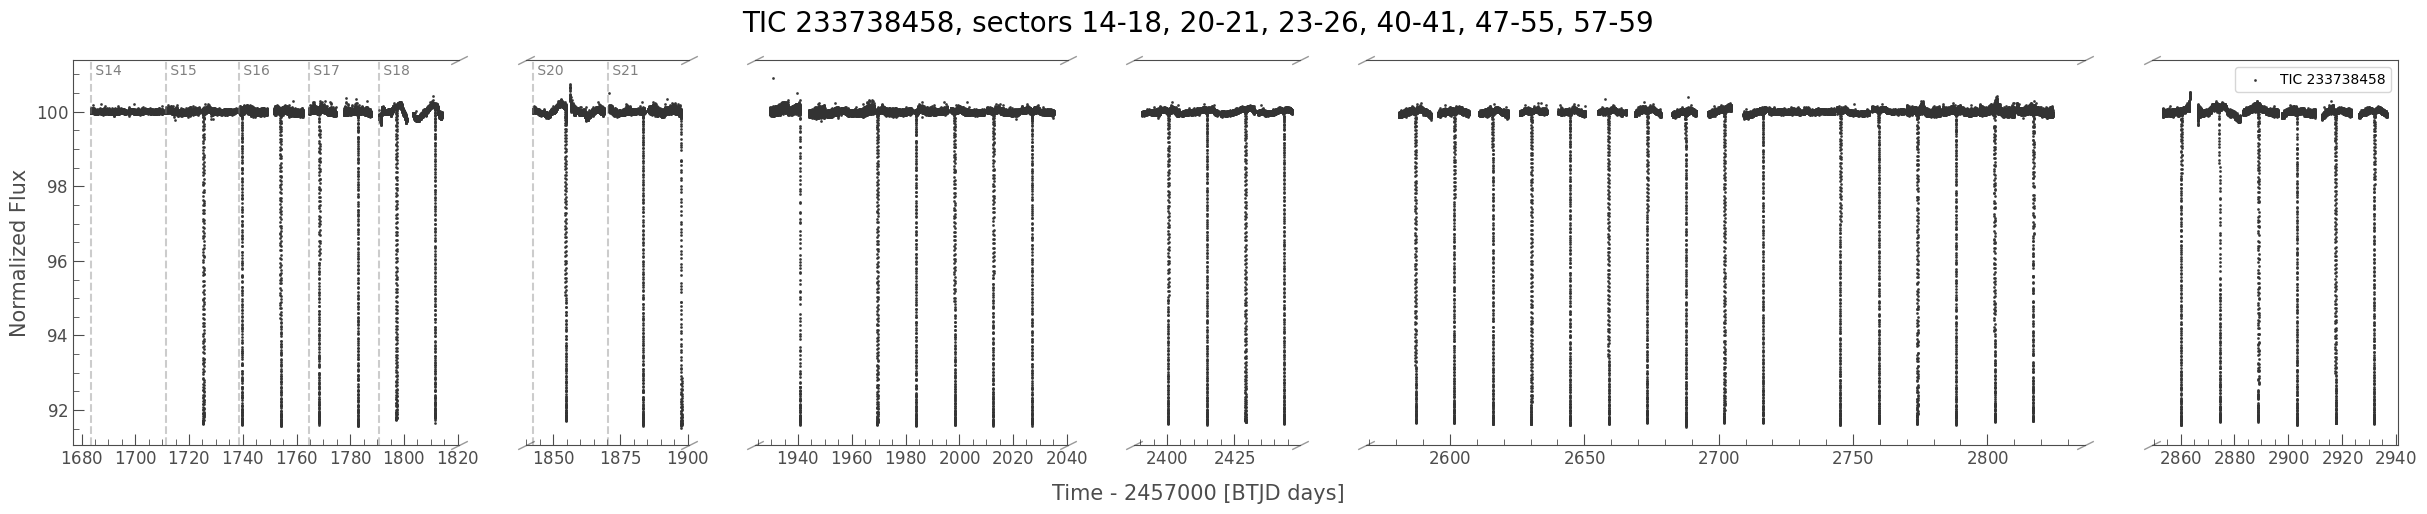

In [5]:
lc_all = lke.stitch(
    lc_coll,
    corrector_func=lambda lc: (
        lc
        .remove_nans()
        .normalize(unit="percent")
    ),
    ignore_incompatible_column_warning=True,
)

print(f"Sectors {lke.abbrev_sector_list(lc_all.meta['SECTORS'])}:")
axs = tplt.plot_skip_data_gap(lc_all, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc_all.label}, sectors {lke.abbrev_sector_list(lc_all)}", fontsize=20);

In [6]:
# FILL-IN THE eclipse epoch / period
tt_spec = dict(epoch=1696.6327, duration_hr=6.8573, period=14.364654, label="s0014-s0060:TCE1",)

In [10]:
zoom_factor = 0.1  # with duration as base

def zoom_lc_f(lc_f):
    return lc_f.truncate(0 - zoom_factor * tt_spec['duration_hr'] / 24, 0 + zoom_factor * tt_spec['duration_hr'] / 24 ).remove_nans()


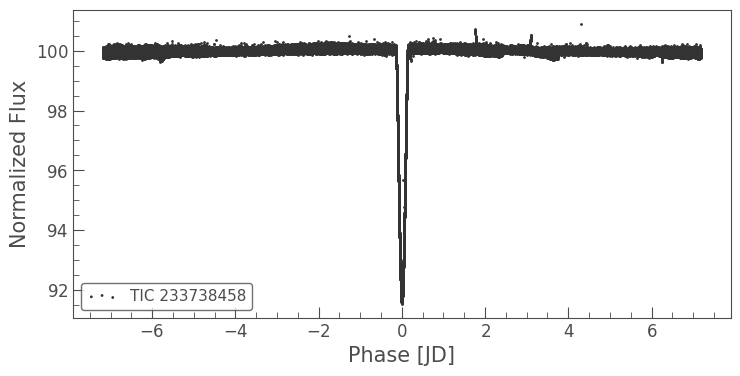

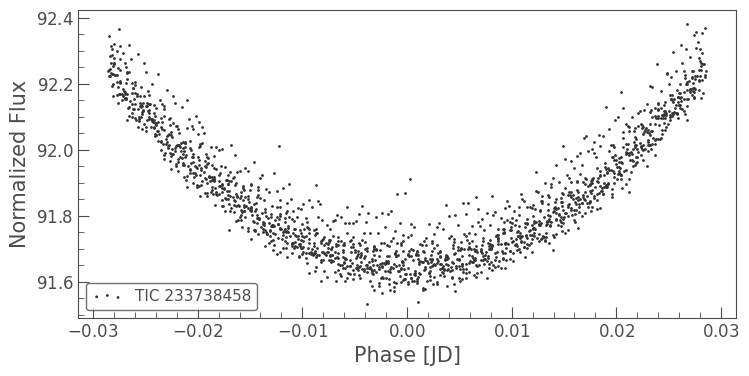

In [16]:
lc_folded = lc_all[:].fold(epoch_time=tt_spec['epoch'], period=tt_spec['period'])

ax = lc_folded.scatter();  # whole folded lightcurve
ax = zoom_lc_f(lc_folded).scatter();

(233738458, 42)

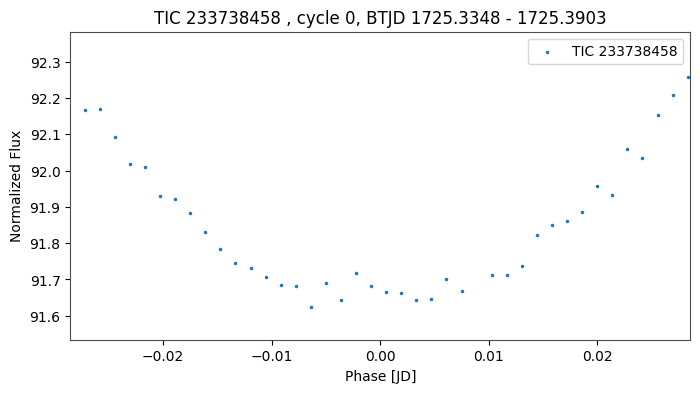

In [15]:
# zoom-in and animate
ax = tplt.lk_ax(figsize=(8, 4))
with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
    lc_to_use = lc_folded
    lc_to_use = zoom_lc_f(lc_to_use)  # zoom in around transit
    # lc_to_use.time.format = 'hour'  # format in hours in lightkurve_ext
    tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));
lc_to_use.meta.get("TARGETID"), len(np.unique(tplt.calc_cycles(lc_to_use)))

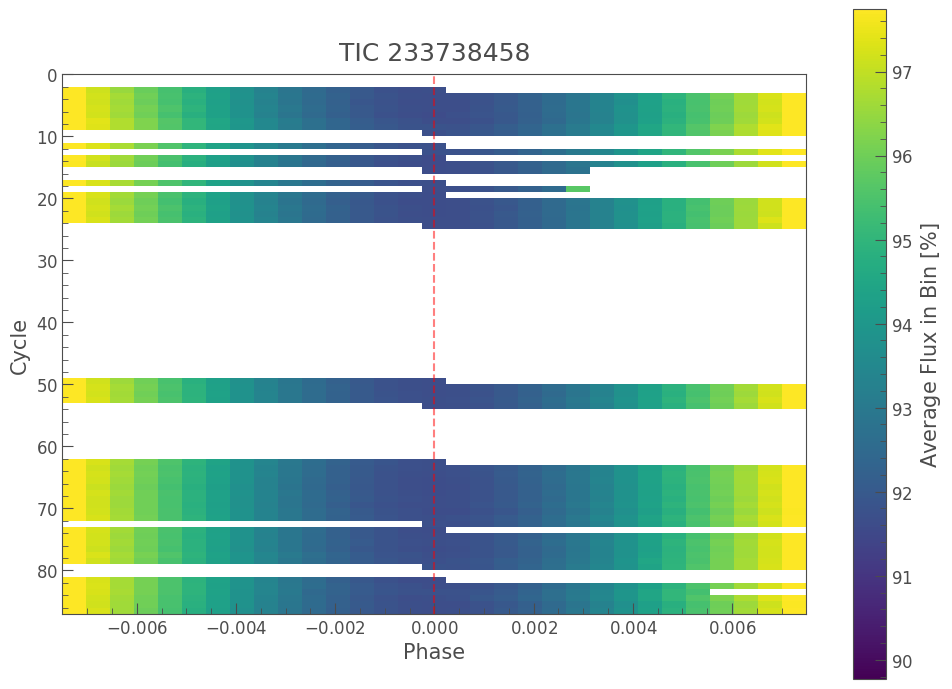

In [23]:
ax = lc_folded[:].plot_river(
    bin_points=5,
#     method='median',  # sigma
    minimum_phase=-0.0075,
    maximum_phase=0.0075,
);
ax.axvline(0, linestyle="--", c="red", alpha=0.5);

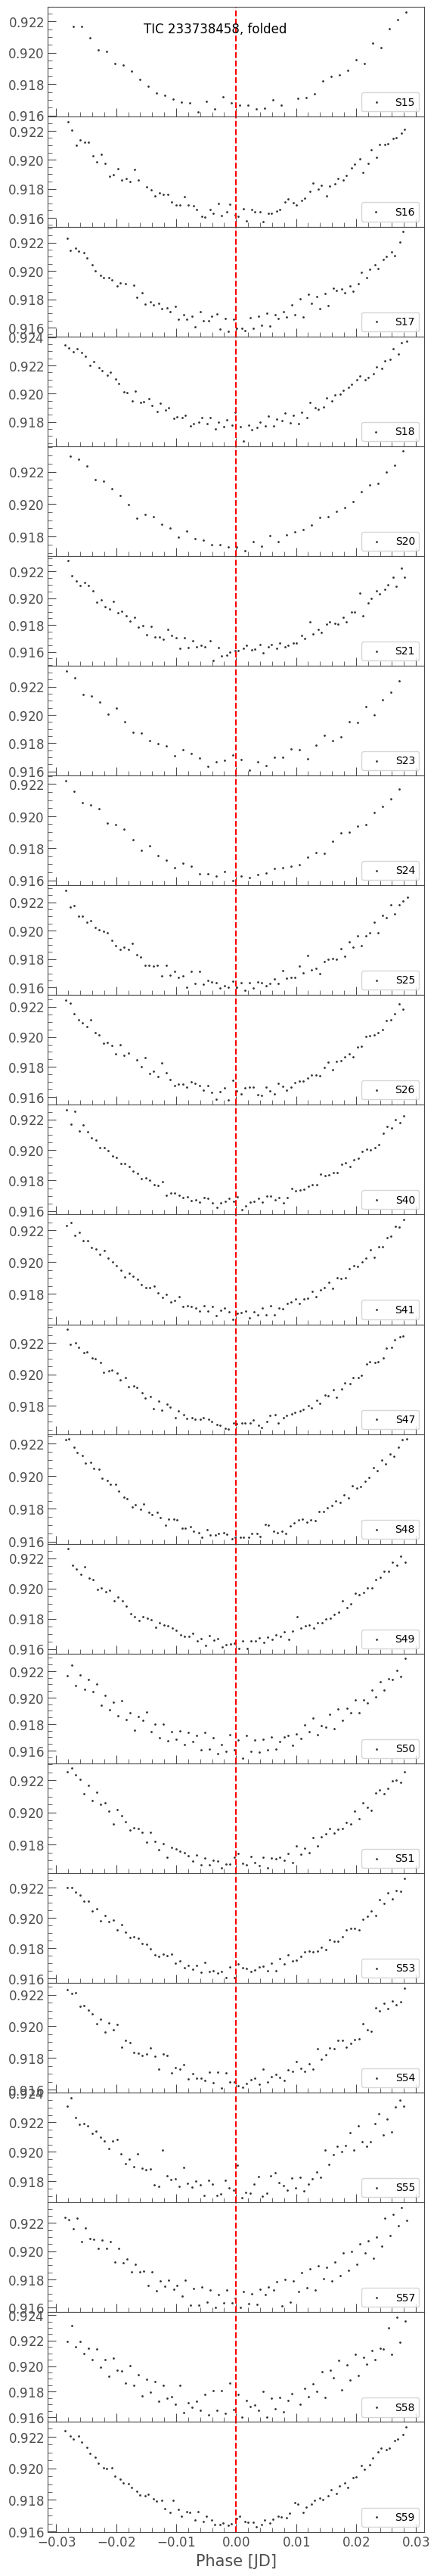

In [24]:
lc_fold_coll = [
    lc.fold(epoch_time=tt_spec['epoch'], period=tt_spec['period'])
    for lc in lc_coll
]

# to filter out sectors with no data around the predicted dips
lc_fold_coll_filtered = [
    lc_f
    for lc_f in lc_fold_coll
    if len(zoom_lc_f(lc_f)) > 0
]

with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(len(lc_fold_coll_filtered), 1, figsize=(6, 1.5 * len(lc_fold_coll_filtered)), sharex=True)

for lc_f, ax in zip(lc_fold_coll_filtered, axs):
    lc_f =  lc_f.normalize()
    lc_f.label = f"S{lc_f.sector}"
    ax = zoom_lc_f(lc_f.normalize()).scatter(ax=ax);
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.axvline(0, color="red", linestyle="--");
    ax.legend(loc="lower right")

fig.suptitle(f"TIC {tic}, folded");
axs[-1].set_xlabel("Phase [JD]");

plt.tight_layout();
plt.subplots_adjust(hspace=0)